In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim
import copy
import matplotlib.pyplot as plt

In [2]:
batch_size = 256
learning_rate = 0.001
epochs = 1000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
fmnist_train = datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_test = datasets.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_train, fmnist_val=torch.utils.data.random_split(fmnist_train, [50000, 10000])

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
dataloader=dict()
dataloader["train"]=DataLoader(fmnist_train, batch_size, shuffle=True)
dataloader["val"]=DataLoader(fmnist_val, batch_size, shuffle=False)
dataloader["test"]=DataLoader(fmnist_test, batch_size, shuffle=False)

In [7]:
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()
    self.encoder=nn.Sequential(
        nn.Linear(28*28, 400),
        nn.ReLU(),
        nn.Linear(400, 200),
        nn.ReLU(),
        nn.Linear(200, 100),
        nn.ReLU()
    )
    self.decoder=nn.Sequential(
        nn.Linear(100, 200),
        nn.ReLU(),
        nn.Linear(200, 400),
        nn.ReLU(),
        nn.Linear(400, 784),
        nn.ReLU()
    )
  def forward(self, x):
    x=x.reshape(-1, 28*28)
    encoded=self.encoder(x)
    out=self.decoder(encoded).reshape(-1, 1, 28, 28)
    return out, encoded

In [8]:
model=AE().to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
best_model=copy.deepcopy(model.state_dict())
best_eval_loss=float('inf')
train_history=[]
eval_history=[]
for epoch in range(epochs):
  for phase in ["train", "val"]:
    if phase=="train":
      model.train()
    else:
      model.eval()
    for x,y in dataloader[phase]:
      x=x.to(device)
      y=y.to(device)
      optimizer.zero_grad()

      output,encoded=model(x)
      loss=criterion(output, x)

      if phase=="train":
        loss.backward()
        optimizer.step()
      
    cur_loss=loss.item()
    if phase=="train":
      print(f'Epoch {epoch}/{epochs-1}')
      print(f'train loss: {cur_loss}')
      train_history.append(cur_loss)
    else:
      print(f'val loss: {cur_loss}')
      print()
      eval_history.append(cur_loss)
      if cur_loss<best_eval_loss:
        best_eval_loss=cur_loss
        best_model=copy.deepcopy(model.state_dict())

print(f'Best Validation Loss: {best_eval_loss}')

Epoch 0/999
train loss: 0.02978554368019104
val loss: 0.030119633302092552

Epoch 1/999
train loss: 0.026328641921281815
val loss: 0.024728305637836456

Epoch 2/999
train loss: 0.020617134869098663
val loss: 0.022266190499067307

Epoch 3/999
train loss: 0.018188051879405975
val loss: 0.02009986899793148

Epoch 4/999
train loss: 0.01849885657429695
val loss: 0.019438888877630234

Epoch 5/999
train loss: 0.01921573095023632
val loss: 0.018939968198537827

Epoch 6/999
train loss: 0.016249792650341988
val loss: 0.01788649894297123

Epoch 7/999
train loss: 0.017677057534456253
val loss: 0.017748476937413216

Epoch 8/999
train loss: 0.018683461472392082
val loss: 0.01720580644905567

Epoch 9/999
train loss: 0.015171918086707592
val loss: 0.017373481765389442

Epoch 10/999
train loss: 0.0181012824177742
val loss: 0.01673249341547489

Epoch 11/999
train loss: 0.014856269583106041
val loss: 0.01641763001680374

Epoch 12/999
train loss: 0.015217269770801067
val loss: 0.01625203900039196

Epoch 1

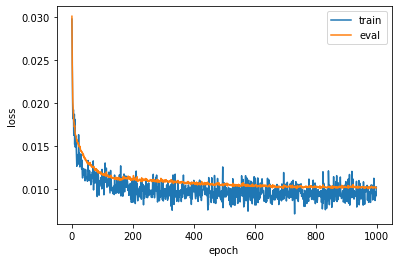

In [10]:
plt.plot(train_history, label="train")
plt.plot(eval_history, label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [11]:
model.load_state_dict(best_model)
total=0
correct=0
with torch.no_grad():
  for x,y in dataloader["test"]:
    x=x.to(device)
    y=y.to(device)

    output,encoded=model(x)
    loss=criterion(output, x)

  print(loss.item())

0.012926596216857433


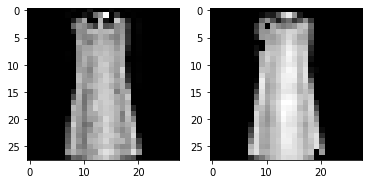

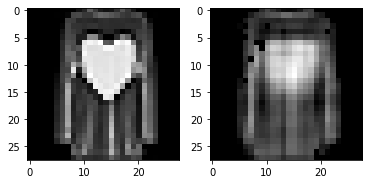

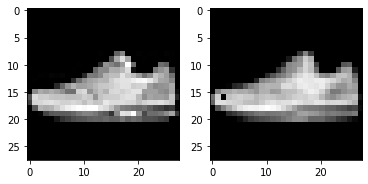

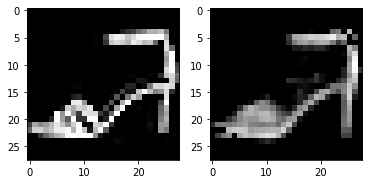

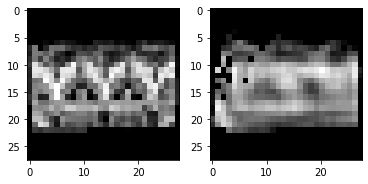

In [12]:
out_img = torch.squeeze(output.cpu().data)
for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(x[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()